# Proyecto 3 - BD2

Importamos la libería face_recognition y probamos que efectivamente detecte si 2 rostros son iguales.

In [10]:
import face_recognition

path1 = "./vindiesel.jpg"
path2 = "./vindiesel2.jpg"
path3 = "./michelleRodriguez.jpg"

image1 = face_recognition.load_image_file(path1)
image2 = face_recognition.load_image_file(path2)
image3 = face_recognition.load_image_file(path3)

face_encoding1 = face_recognition.face_encodings(image1)[0]
face_encoding2 = face_recognition.face_encodings(image2)[0]
face_encoding3 = face_recognition.face_encodings(image3)[0]

comp1 = face_recognition.compare_faces([face_encoding2], face_encoding1)
comp2 = face_recognition.compare_faces([face_encoding3], face_encoding1)

print(comp1)
print(comp2)


[True]
[False]


Hemos confirmado que la librería funciona. Ahora, implementamos la búsqueda secuencial por top-k. Para ello, utilizaremos un maxHeap que guarde en su raíz siempre al k peor candidato. Cuando venga un mejor candidato, podremos hacer pop del k peor candidato e insertar en el heap al nuevo candidato en la posición a la que corresponda.

In [10]:
import os
import heapq        #en python no hay implementación de un maxheap, para ello multiplicaremos por -1 las distancias en el heap
import face_recognition
import time

def sequential_knn(k, target_face_encoding):
    dataset_path = "./lfw-chikito"
    face_encodings = []

    # Recorre las subcarpetas del dataset
    for person_folder in os.listdir(dataset_path):
        person_folder_path = os.path.join(dataset_path, person_folder)

        # Recorre las imágenes de cada persona
        for image_file in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, image_file)

            # Carga la imagen y extrae el código de codificación facial
            image = face_recognition.load_image_file(image_path)
            face_locations = face_recognition.face_locations(image)

            # Verifica si se detectó al menos una cara en la imagen
            if len(face_locations) > 0:
                encoding = face_recognition.face_encodings(image, face_locations)[0]

                # Calcula la distancia entre el código de codificación facial objetivo y el actual
                distance = -face_recognition.face_distance([target_face_encoding], encoding)[0]  # Invierte el signo tal que el mayor del heap siempre estará en la raíz

                # Si el heap no tiene k elementos, agrega el candidato actual
                if len(face_encodings) < k:
                    heapq.heappush(face_encodings, (distance, person_folder))
                else:
                    #
                    if abs(distance) < abs(face_encodings[0][0]):  # si la distancia del candidato es menor al mayor del heap,
                        heapq.heappushpop(face_encodings, (distance, person_folder))    #quita el mayor e inserta el candidato


    # Multiplicar por -1 a las distancias para regresarlas a la normalidad
    face_encodings = [(-x, y) for x, y in face_encodings]

    # Ordenar los resultados por distancia de manera ascendente. Es necesario porque estoy usando maxHeap
    top_k_faces = sorted(face_encodings, key=lambda x: abs(x[0]))

    return top_k_faces


# Cargar la imagen de la persona que se busca
target_image_path = "./lfw-chikito/Aaron_Tippin/Aaron_Tippin_0001.jpg"
target_image = face_recognition.load_image_file(target_image_path)
target_face_encoding = face_recognition.face_encodings(target_image)[0]

# Definir el valor de k
k = 8

# Realizar la búsqueda secuencial KNN
inicio = time.time()
top_k_faces = sequential_knn(k, target_face_encoding)
fin = time.time()

# Tiempo en ms
duracion = (fin-inicio)

# Imprimir los resultados
print(f"Las {k} mejores coincidencias de rostros son: {top_k_faces}")
print("Tiempo que demoró el KNN secuencial (top k): ", duracion, "segundos")

Las 8 mejores coincidencias de rostros son: [(0.0, 'Aaron_Tippin'), (0.5976700847353551, 'Abdullah_Gul'), (0.6251211467411852, 'Abid_Hamid_Mahmud_Al-Tikriti'), (0.6323579379429556, 'Abdullatif_Sener'), (0.6396712820510758, 'Abdullah_Gul'), (0.6478252059084803, 'Abdullah_Gul'), (0.6588828885324005, 'Abdullah_Gul'), (0.6597195673472774, 'Adam_Kennedy')]
Tiempo que demoró el KNN secuencial (top k):  48.561139822006226 segundos


Ahora, implementaremos la búsqueda secuencial por rango. Para ello, primero necesitamos un análisis de la distribución de las distancias para determinar cuál rango es oportuno pasarle a la función. Cabe resaltar que este análisis se debe de hacer para cada query que necesitemos, por lo cual no es muy óptimo realizar este tipo de consulta.

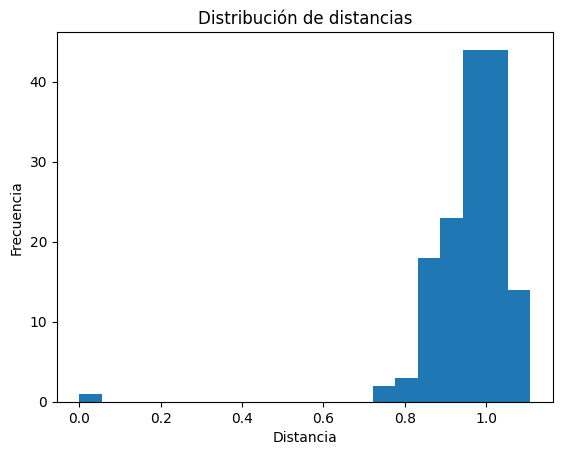

Análisis de la distribución de distancias:
Media: 0.9625379301797001
Desviación estándar: 0.10774648030455632
Distancia mínima: 0.0
Distancia máxima: 1.1087281186364872


In [21]:
import os
import face_recognition
import numpy as np
import matplotlib.pyplot as plt

def distance_analysis(target_face_encoding):
    dataset_path = "./lfw-chikito"
    distances = []

    # Recorre las subcarpetas del dataset
    for person_folder in os.listdir(dataset_path):
        person_folder_path = os.path.join(dataset_path, person_folder)

        # Recorre las imágenes de cada persona
        for image_file in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, image_file)

            # Carga la imagen y extrae el código de codificación facial
            image = face_recognition.load_image_file(image_path)
            face_locations = face_recognition.face_locations(image)

            # Verifica si se detectó al menos una cara en la imagen
            if len(face_locations) > 0:
                encoding = face_recognition.face_encodings(image, face_locations)[0]

                # Calcula la distancia entre el código de codificación facial objetivo y el actual
                distance = face_recognition.face_distance([target_face_encoding], encoding)[0]
                distances.append(distance)

    # Realiza el análisis estadístico de las distancias
    distances = np.array(distances)
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    min_distance = np.min(distances)
    max_distance = np.max(distances)

    # Genera un histograma de las distancias
    plt.hist(distances, bins=20)
    plt.title("Distribución de distancias")
    plt.xlabel("Distancia")
    plt.ylabel("Frecuencia")
    plt.show()

    # Imprime los resultados del análisis estadístico
    print("Análisis de la distribución de distancias:")
    print(f"Media: {mean_distance}")
    print(f"Desviación estándar: {std_distance}")
    print(f"Distancia mínima: {min_distance}")
    print(f"Distancia máxima: {max_distance}")

# Cargar la imagen de la persona que se busca
target_image_path = "./lfw-chikito/AJ_Cook/AJ_Cook_0001.jpg"
target_image = face_recognition.load_image_file(target_image_path)
target_face_encoding = face_recognition.face_encodings(target_image)[0]

# Realizar el análisis de distribución de distancias
distance_analysis(target_face_encoding)


A continuación implementaremos la función de la búsqueda por rango utilizando la misma idea del Maxheap que en el KNN top k. Además, le pasaremos a la función ngo [0.9, 0.95], ya que del análisis de la distribución de los datos sabemos que son varios los resultados en este rango. 

In [2]:
import os
import face_recognition

def sequential_range_KNN(target_face_encoding, distance_range):
    dataset_path = "./lfw-chikito"
    face_encodings = []

    # Recorre las subcarpetas del dataset
    for person_folder in os.listdir(dataset_path):
        person_folder_path = os.path.join(dataset_path, person_folder)

        # Recorre las imágenes de cada persona
        for image_file in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, image_file)

            # Carga la imagen y extrae el código de codificación facial
            image = face_recognition.load_image_file(image_path)
            face_locations = face_recognition.face_locations(image)

            # Verifica si se detectó al menos una cara en la imagen
            if len(face_locations) > 0:
                encoding = face_recognition.face_encodings(image, face_locations)[0]

                # Calcula la distancia entre el código de codificación facial objetivo y el actual
                distance = face_recognition.face_distance([target_face_encoding], encoding)[0]

                # Verifica si la distancia está dentro del rango especificado
                if distance >= distance_range[0] and distance <= distance_range[1]:
                    face_encodings.append((distance, person_folder))


    # Ordenar los resultados por distancia de manera ascendente
    top_faces = sorted(face_encodings, key=lambda x: abs(x[0]))

    return top_faces



# Cargar la imagen de la persona que se busca
target_image_path = "./lfw-chikito/AJ_Cook/AJ_Cook_0001.jpg"
target_image = face_recognition.load_image_file(target_image_path)
target_face_encoding = face_recognition.face_encodings(target_image)[0]

# Definir el rango de distancia aceptable (por ejemplo, entre 0.9 y 0.95)
distance_range = (0.9, 0.95)

# Realizar la búsqueda secuencial de KNN dentro del rango especificado
inicio = time.time()
top_faces = sequential_range_KNN(target_face_encoding, distance_range)
fin = time.time()

duracion = fin-inicio

# Imprimir los resultados
print(f"Las coincidencias de rostros dentro del rango {distance_range} son: {top_faces}")
print("Tiempo que demora la búsqueda por rango secuencial:",duracion,"segundos")

Las coincidencias de rostros dentro del rango (0.9, 0.95) son: [(0.902954223603258, 'Ai_Sugiyama'), (0.9101778211903887, 'Ai_Sugiyama'), (0.9119158740009002, 'Aitor_Gonzalez'), (0.9162806735318733, 'Aidan_Quinn'), (0.9194783936153695, 'Aaron_Tippin'), (0.9195123056433858, 'Abdullah_Ahmad_Badawi'), (0.9195934234870634, 'Ai_Sugiyama'), (0.9205411195847143, 'Adam_Herbert'), (0.9236175685398942, 'Abdel_Nasser_Assidi'), (0.9277162037552665, 'Abel_Pacheco'), (0.931889764586383, 'Abdullatif_Sener'), (0.9330896176778148, 'Adam_Rich'), (0.9333003251143436, 'Abdullatif_Sener'), (0.9342669630684443, 'Abdel_Nasser_Assidi'), (0.9395429290570808, 'Adolfo_Rodriguez_Saa'), (0.9402972370301503, 'Abner_Martinez'), (0.9404769538153271, 'Aicha_El_Ouafi'), (0.9416246724362973, 'Abdullah_Nasseef'), (0.942219436756485, 'Adam_Mair'), (0.9440161978717541, 'Aicha_El_Ouafi'), (0.9447200842527941, 'Adam_Kennedy'), (0.945812949276043, 'Abdullah_Gul'), (0.9465291462569932, 'Abraham_Foxman'), (0.9472559333886676, 'A

Luego, realizaremos la búsqueda KNN (top-k) con el R-tree de Python:

In [11]:
import os
import face_recognition
from rtree import index
import time

personas = {}

# Función que indexa al árbol los face_encodings
def build_rtree_index(dataset_path):
    p = index.Property()
    p.dimension = 128  # El número de dimensiones es 128 para los face_encodings

    idx = index.Index(properties=p)
    id_counter = 0

    # Recorre las subcarpetas del dataset
    for person_folder in os.listdir(dataset_path):
        person_folder_path = os.path.join(dataset_path, person_folder)
        person_name = os.path.basename(person_folder_path)

        # Recorre las imágenes de cada persona
        for image_file in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, image_file)

            # Carga la imagen y extrae el código de codificación facial
            image = face_recognition.load_image_file(image_path)
            face_locations = face_recognition.face_locations(image)

            # Verifica si se detectó al menos una cara en la imagen
            if len(face_locations) > 0:
                encoding = face_recognition.face_encodings(image, face_locations)[0]

                # Agrega el encoding al índice R-tree
                idx.insert(id_counter, encoding, (id_counter, id_counter))
                personas[id_counter] = person_name
                id_counter += 1

    return idx

# Función que realiza el knn-search con el Rtree
def rtree_knn_search(idx, target_face_encoding, k):
    results = list(idx.nearest(target_face_encoding, num_results=k))

    return results



# Cargar la imagen de la persona que se busca
target_image_path = "./lfw-chikito/Aaron_Tippin/Aaron_Tippin_0001.jpg"
target_image = face_recognition.load_image_file(target_image_path)
target_face_encoding = face_recognition.face_encodings(target_image)[0]

# Definir el valor de k (por ejemplo, 5)
k = 8

# Construir el índice R-tree
dataset_path = "./lfw-chikito"
idx = build_rtree_index(dataset_path)

# Realizar la búsqueda kNN utilizando el R-tree
inicio = time.time()
indices = rtree_knn_search(idx, target_face_encoding, k) # los indices estarán ordenados de menor a mayor distancia con respecto al target_face_encoding.
fin = time.time()

duracion = fin-inicio

# Halar aquellas personas correspondientes a esos resultados en ese orden
results = []

for indice in indices:
    results.append(personas[indice])

print("Top", k,"(de menor a mayor distancia de la query):", results)
print("Tiempo que demora el KNN search con RTree:", duracion, "segundos")




Top 8 (de menor a mayor distancia de la query): ['Aaron_Tippin', 'Abdullah_Gul', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abdullatif_Sener', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Adam_Kennedy']
Tiempo que demora el KNN search con RTree: 0.0009565353393554688 segundos


Como se puede observar, el primer resultado de la lista es justamente la query, lo que verifica que nuestro top k es correcto.

## Elección de árbol para muchas dimensiones

### Técnica PCA
Reduce la cantidad de dimensiones de los datos originales con el objetivo de minimizar los costos de búsqueda. No obstante, esto sacrifica la precisión, retornando así una aproximación a la query. A continuación, se mostrará el código para guardar el vector de características en memoria secundaria para evitar extraerlo cada vez que se realiza una consulta.

In [5]:
import numpy as np
import face_recognition
import os
#librerías para PCA
from sklearn.decomposition import PCA
# Libreria para la búsqueda de vecinos más cercanos
from sklearn.neighbors import NearestNeighbors
import time
import pickle



# Extrae el vector de características de los rostros

def encodings(dataset_path):
    face_encodings = []

    for person_folder in os.listdir(dataset_path):
        person_folder_path = os.path.join(dataset_path, person_folder)
        person_name = os.path.basename(person_folder_path)

        # Recorre las imágenes de cada persona
        for image_file in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, image_file)

            # Carga la imagen y extrae el código de codificación facial
            image = face_recognition.load_image_file(image_path)
            face_locations = face_recognition.face_locations(image)

            # Verifica si se detectó al menos una cara en la imagen
            if len(face_locations) > 0:
                encoding = face_recognition.face_encodings(image, face_locations)[0]
                face_encodings.append((encoding, person_name))

    return face_encodings



def save_encodings(face_encodings, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(face_encodings, file)


dataset_path = "./lfw"

face_encodings = encodings(dataset_path)  #Este proceso debemos evitarlo en la búsqueda guardando los face_encodings en memoria secundaria

save_encodings(face_encodings,"face_encodings.pkl") # Guardamos



Ya guardado el vector característico, la búsqueda se realizaría de la siguiente manera:

In [6]:
import numpy as np
import face_recognition
import os
#librerías para PCA
from sklearn.decomposition import PCA
# Libreria para la búsqueda de vecinos más cercanos
from sklearn.neighbors import NearestNeighbors
import time
import pickle


# Solución elegida : Principal Component Analysis (PCA)

# PCA es una técnica de reducción de dimensionalidad que se utiliza para reducir la dimensionalidad

def PCA_(face_encondings,image_path ,n_components=0.95, N=5):
    # extraer los vectores de codificación facial de la lista de tuplas
    face_encodings = [face_encoding[0] for face_encoding in face_encondings]

    # crear una matriz numpy de los vectores de codificación facial
    X = np.array(face_encodings)

    # crear un objeto PCA
    pca = PCA(n_components=n_components)

    # ajustar el objeto PCA a los vectores de codificación facial
    X_transformed = pca.fit_transform(X)

    # crear un objeto NearestNeighbors
    
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(X_transformed)
    

    # extraer el vector de codificación facial de la imagen de consulta
    image = face_recognition.load_image_file(image_path)
    face_locations = face_recognition.face_locations(image)

    # Verifica si se detectó al menos una cara en la imagen
    if len(face_locations) > 0:
        query = face_recognition.face_encodings(image, face_locations)[0]

        # transformar el vector de codificación facial de la imagen de consulta
        query = pca.transform([query])

        # encontrar los N vecinos más cercanos de la imagen de consulta
        inicio = time.time()
        distances, indices = nbrs.kneighbors(query)
        fin = time.time()
        duracion = fin-inicio

        # imprimir los N vecinos más cercanos
        for rank, index in enumerate(indices[0][:N], start=1):
            print(f"Rank {rank}\t{face_encondings[index][1]}")

        print("Duración de búsqueda con PCA:",duracion,"segundos")



def load_encodings(file_path):
    with open(file_path, 'rb') as file:
        face_encodings = pickle.load(file)
    return face_encodings



image_path = "./lfw/Aaron_Tippin/Aaron_Tippin_0001.jpg"


face_encodings = load_encodings("face_encodings.pkl")

N = 8

PCA_(face_encodings,image_path,0.95,N)

Rank 1	Aaron_Tippin
Rank 2	Scott_Wittman
Rank 3	Fernando_Leon_de_Aranoa
Rank 4	Ismail_Merchant
Rank 5	Branko_Crvenkovski
Rank 6	Sergio_Vieira_De_Mello
Rank 7	Hector_Babenco
Rank 8	Javier_Solana
Duración de búsqueda con PCA: 0.016998291015625 segundos


### Técnica LSH
Trae mejores resultados, pero no trae un número determinado de éstos, sino que depende de la similitud que tenga la query con el dataset. Como nosotros buscamos un KNN-search, no conviene utilizar esta técnica, pues es incierto si realmente podrá traer los k elementos.

In [1]:
import numpy as np
import face_recognition
import os
#Librerías para LSH
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
# KNN-HighD 

# Solución elegida : Locality Sensitive Hashing (LSH)

# LSH es una técnica usada en computer science para la búsqueda eficiente en espacios
# de alta dimensionalidad. Se trata de un algoritmo basado en hashing que asigna puntos de datos
# de alta dimensión a códigos hash de menor dimensión, de forma que es más probable
# que los puntos de datos similares se asignen al mismo código hash.

# LSH es una técnica de búsqueda aproximada, lo que significa que no siempre encuentra

personas = {}

def LSH(dataset_path):
    #Crear el motor NearPy con LSH
    dimension = 128
    rbp = RandomBinaryProjections('rbp', 10)
    engine = Engine(dimension, lshashes=[rbp])

    #Agregar los vectores de cada imagen al motor NearPy
    for person_folder in os.listdir(dataset_path):
        person_folder_path = os.path.join(dataset_path, person_folder)
        person_name = os.path.basename(person_folder_path)

        # Recorre las imágenes de cada persona
        for image_file in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, image_file)

            # Carga la imagen y extrae el código de codificación facial
            image = face_recognition.load_image_file(image_path)
            face_locations = face_recognition.face_locations(image)

            # Verifica si se detectó al menos una cara en la imagen
            if len(face_locations) > 0:
                encoding = face_recognition.face_encodings(image, face_locations)[0]

                # Agrega el vector de codificación facial al motor NearPy
                engine.store_vector(encoding, person_name)

    return engine

def search(engine, image_path, N):
    # Carga la imagen y extrae el código de codificación facial
    image = face_recognition.load_image_file(image_path)
    face_locations = face_recognition.face_locations(image)

    # Verifica si se detectó al menos una cara en la imagen
    if len(face_locations) > 0:
        encoding = face_recognition.face_encodings(image, face_locations)[0]

        # Busca los N vecinos más cercanos
        N_nearest_neighbors = engine.neighbours(encoding)

        # cont = 0
        # for i in N_nearest_neighbors:
        #     print("obj",cont+1,":",i[1] )
        #     cont += 1

        # Imprime los N vecinos más cercanos
        print("Los " + str(N) + " vecinos más cercanos a la imagen " + image_path + " son:")

        for i in range(N):
            print(N_nearest_neighbors[i][1])

def main():
    dataset_path = "./lfw-chikito"
    engine = LSH(dataset_path)
    image_path = "./lfw-chikito/Aaron_Tippin/Aaron_Tippin_0001.jpg"
    search(engine, image_path, 10)

main()


KeyboardInterrupt: 